**Main RGB Experiments**
Using the architecture provided in Assignment 2, I will run the my control experiment. In this file, I will train a ResNet model on RGB CIFAR-10 images and then test the model on RGB images. I will use these findings as a baseline to compare other experimental condtiions. 

###The following code will be repeated for each experimental section to set up the workspace

In [ ]:
# The following code will be repeated for each experimental section>
### General libraries useful for python ###

import os
import sys
from tqdm.notebook import tqdm
import json
import random
import pickle
import copy
from IPython.display import display
import ipywidgets as widgets

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
### Finding where you clone your repo, so that code upstream paths can be specified programmatically ####
git_dir = '/content/drive/MyDrive/Harvard_BAI'
print('Your github directory is :%s'%git_dir)

Your github directory is :/content/drive/MyDrive/Harvard_BAI


In [ ]:
project_folder= "%s/Colorblind_Machines_Neuro140"%git_dir

In [ ]:
# Change into project folder
os.chdir(project_folder)

In [ ]:
### Libraries for visualizing our results and data ###
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
### Import PyTorch and its components ###
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

#### Now we will load our code bases from assignment 2 

In [ ]:
### Making helper code under the folder res available. This includes loaders, models, etc. ###
sys.path.append('%s/res/'%git_dir)
from models.models import get_model
from loader.loader import get_loader

Models are being loaded from: /content/drive/MyDrive/Harvard_BAI/res/models
Loaders are being loaded from: /content/drive/MyDrive/Harvard_BAI/res/loader


In [ ]:
### Setting up Weights and Biases for tracking your experiments. ###

## We have Weights and Biases (wandb.ai) integrated into the code for easy visualization of results and for tracking performance. 

%pip install --upgrade git+git://github.com/wandb/client.git@task/debug-init-wandb#egg=wandb
import wandb
wandb.login()

  Cloning git://github.com/wandb/client.git (to revision task/debug-init-wandb) to /tmp/pip-install-_7xl2qvk/wandb
  Running command git clone -q git://github.com/wandb/client.git /tmp/pip-install-_7xl2qvk/wandb
  Running command git checkout -b task/debug-init-wandb --track origin/task/debug-init-wandb
  Switched to a new branch 'task/debug-init-wandb'
  Branch 'task/debug-init-wandb' set up to track remote branch 'task/debug-init-wandb' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163kB 5.2MB/s 
     |████████████████████████████████| 133kB 6.3MB/s 
     |████████████████████████████████| 102kB 5.1MB/s 
     |████████████████████████████████| 71kB 6.2MB/s 
  Created wheel for wandb: filename=wandb-0.10.18.dev1-cp37-none-any.whl size=2009263 sha256=9a29e867324bca6eb85501118d736e7f9661ba00fe75a5a1f63bb8518da8d57e
  Stored in directory: /tmp/pip-ephem-w

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Specifying settings/hyperparameters for the code below ###

In [ ]:
wandb_config = {}
wandb_config['batch_size'] = 10
wandb_config['base_lr'] = 0.01
wandb_config['model_arch'] = 'ResNet18'
wandb_config['num_classes'] = 10
wandb_config['run_name'] = 'main_rgb'

### If you are using a CPU, please set wandb_config['use_gpu'] = 0 below. However, if you are using a GPU, leave it unchanged ####
wandb_config['use_gpu'] = 1

# Number of times to pass through the data
wandb_config['num_epochs'] = 2

wandb_config['git_dir'] = git_dir

### Create file list of all image files

In [ ]:
print(os.listdir('%s/data/CIFAR-10-images-master/train_rgb/'%project_folder))
train_folder_files = os.listdir('%s/data/CIFAR-10-images-master/train_rgb/'%project_folder)
random.shuffle(train_folder_files)

['deer.3014.jpg', 'deer.3772.jpg', 'deer.3799.jpg', 'deer.1830.jpg', 'deer.3000.jpg', 'deer.0290.jpg', 'deer.1818.jpg', 'deer.4784.jpg', 'deer.4974.jpg', 'deer.0284.jpg', 'deer.1824.jpg', 'deer.4790.jpg', 'deer.2493.jpg', 'deer.4948.jpg', 'deer.4960.jpg', 'deer.3955.jpg', 'deer.3969.jpg', 'deer.1987.jpg', 'deer.4627.jpg', 'deer.2530.jpg', 'deer.4141.jpg', 'deer.2256.jpg', 'deer.0441.jpg', 'deer.3148.jpg', 'deer.1039.jpg', 'deer.4989.jpg', 'deer.4751.jpg', 'deer.2452.jpg', 'deer.4023.jpg', 'deer.4745.jpg', 'deer.2334.jpg', 'deer.0245.jpg', 'deer.3994.jpg', 'deer.0251.jpg', 'deer.4037.jpg', 'deer.3758.jpg', 'deer.2446.jpg', 'deer.3980.jpg', 'deer.0523.jpg', 'deer.2863.jpg', 'deer.0912.jpg', 'deer.3566.jpg', 'deer.0084.jpg', 'deer.2678.jpg', 'deer.4209.jpg', 'deer.2693.jpg', 'deer.4584.jpg', 'deer.4590.jpg', 'deer.0906.jpg', 'deer.2877.jpg', 'deer.3599.jpg', 'deer.2687.jpg', 'deer.0090.jpg', 'deer.1371.jpg', 'deer.1417.jpg', 'deer.0709.jpg', 'deer.2122.jpg', 'deer.4553.jpg', 'deer.4235.jp

In [ ]:
total_points = len(train_folder_files)

In [ ]:
#Setting 80% as training files and the last 20% as validation files
train_files = train_folder_files[:int(0.8*total_points)]
val_files = train_folder_files[int(0.8*total_points):]

In [ ]:
test_files = os.listdir('%s/data/CIFAR-10-images-master/test/'%project_folder)

Need to create txt files for train, val, and test; MAKE sure to indicate if train and val are rgb, gy, etc. 

In [ ]:
#Using standard labeling we will create a dictionary for all the training files
#airplane = 0, automobile= 1; bird=2; cat=3; deer=4; 
#dog=5; frog=6; horse=7; ship = 8; truck=9;
labels_dictionary = {}
with open('data/train_rgb_file_list.txt','w') as F:
    for t in train_files:
        file_path = '%s/data/CIFAR-10-images-master/train_rgb/%s'%(project_folder, t)
        if 'airplane' in t:
            labels_dictionary[file_path] = 0
            print(file_path, file = F)
        elif 'automobile' in t:
            labels_dictionary[file_path] = 1
            print(file_path, file = F)
        elif 'bird' in t:
            labels_dictionary[file_path] = 2
            print(file_path, file = F)
        elif 'cat' in t:
            labels_dictionary[file_path] = 3
            print(file_path, file = F)
        elif 'deer' in t:
            labels_dictionary[file_path] = 4
            print(file_path, file = F)
        elif 'dog' in t:
            labels_dictionary[file_path] = 5
            print(file_path, file = F)
        elif 'frog' in t:
            labels_dictionary[file_path] = 6
            print(file_path, file = F)  
        elif 'horse' in t:
            labels_dictionary[file_path] = 7
            print(file_path, file = F)
        elif 'ship' in t:
            labels_dictionary[file_path] = 8
            print(file_path, file = F)
        elif 'truck' in t:
            labels_dictionary[file_path] = 9
            print(file_path, file = F)
        
with open('data/val_rgb_file_list.txt','w') as F:
    for t in train_files:
        file_path = '%s/data/CIFAR-10-images-master/train_rgb/%s'%(project_folder, t)
        if 'airplane' in t:
            labels_dictionary[file_path] = 0
            print(file_path, file = F)
        elif 'automobile' in t:
            labels_dictionary[file_path] = 1
            print(file_path, file = F)
        elif 'bird' in t:
            labels_dictionary[file_path] = 2
            print(file_path, file = F)
        elif 'cat' in t:
            labels_dictionary[file_path] = 3
            print(file_path, file = F)
        elif 'deer' in t:
            labels_dictionary[file_path] = 4
            print(file_path, file = F)
        elif 'dog' in t:
            labels_dictionary[file_path] = 5
            print(file_path, file = F)
        elif 'frog' in t:
            labels_dictionary[file_path] = 6
            print(file_path, file = F)  
        elif 'horse' in t:
            labels_dictionary[file_path] = 7
            print(file_path, file = F)
        elif 'ship' in t:
            labels_dictionary[file_path] = 8
            print(file_path, file = F)
        elif 'truck' in t:
            labels_dictionary[file_path] = 9
            print(file_path, file = F)

with open('data/test_file_list.txt','w') as F:
    for t in test_files:
        file_path = '%s/data/CIFAR-10-images-master/test/%s'%(project_folder, t)
        if 'airplane' in t:
            labels_dictionary[file_path] = 0
            print(file_path, file = F)
        elif 'automobile' in t:
            labels_dictionary[file_path] = 1
            print(file_path, file = F)
        elif 'bird' in t:
            labels_dictionary[file_path] = 2
            print(file_path, file = F)
        elif 'cat' in t:
            labels_dictionary[file_path] = 3
            print(file_path, file = F)
        elif 'deer' in t:
            labels_dictionary[file_path] = 4
            print(file_path, file = F)
        elif 'dog' in t:
            labels_dictionary[file_path] = 5
            print(file_path, file = F)
        elif 'frog' in t:
            labels_dictionary[file_path] = 6
            print(file_path, file = F)  
        elif 'horse' in t:
            labels_dictionary[file_path] = 7
            print(file_path, file = F)
        elif 'ship' in t:
            labels_dictionary[file_path] = 8
            print(file_path, file = F)
        elif 'truck' in t:
            labels_dictionary[file_path] = 9
            print(file_path, file = F)

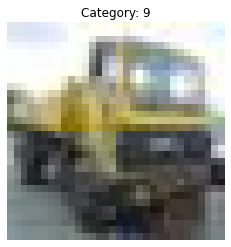

In [ ]:
random_data_point = random.choice(list(labels_dictionary.keys()))
plt.imshow(Image.open(random_data_point))
plt.title('Category: %s'%labels_dictionary[random_data_point])
plt.axis('off')
plt.show()

In [ ]:
with open('%s/data/labels_dictionary_rgb.p'%project_folder, 'wb') as F:
    pickle.dump(labels_dictionary, F)

# Using custom data-loader

Since we formated the data the same, we will use the cat_dogs_loader

In [ ]:
file_list_loader= get_loader('cats_dogs_loader')

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
     'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
dsets = {}
dsets['train'] = file_list_loader('/content/drive/MyDrive/Harvard_BAI/Colorblind_Machines_Neuro140/data/train_rgb_file_list.txt','/content/drive/MyDrive/Harvard_BAI/Colorblind_Machines_Neuro140/data/labels_dictionary_rgb.p', data_transforms['train'])
dsets['val'] = file_list_loader('/content/drive/MyDrive/Harvard_BAI/Colorblind_Machines_Neuro140/data/val_rgb_file_list.txt','/content/drive/MyDrive/Harvard_BAI/Colorblind_Machines_Neuro140/data/labels_dictionary_rgb.p', data_transforms['val'])
dsets['test'] = file_list_loader('/content/drive/MyDrive/Harvard_BAI/Colorblind_Machines_Neuro140/data/test_file_list.txt','/content/drive/MyDrive/Harvard_BAI/Colorblind_Machines_Neuro140/data/labels_dictionary_rgb.p', data_transforms['test'])

In [ ]:
### Above, we created datasets. Now, we will pass them into pytorch's inbuild dataloaders, 
### these will help us load batches of data for training.
dset_loaders = {}
dset_loaders['train'] = torch.utils.data.DataLoader(dsets['train'], batch_size=wandb_config['batch_size'], shuffle = True, num_workers=2,drop_last=False)
dset_loaders['val'] = torch.utils.data.DataLoader(dsets['val'], batch_size=wandb_config['batch_size'], shuffle = False, num_workers=2,drop_last=False)
dset_loaders['test'] = torch.utils.data.DataLoader(dsets['test'], batch_size=wandb_config['batch_size'], shuffle = True, num_workers=2,drop_last=False)

In [ ]:
data_sizes = {}
data_sizes['train'] = len(dsets['train'])
data_sizes['val'] = len(dsets['val'])
data_sizes['test'] = len(dsets['test'])

## Loading model with Pytorch

In [ ]:
model = torchvision.models.resnet18(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


### use get model to load CNN

In [ ]:
### Since we pass ResNet18 below, this will get relayed to 
### the get_model function loaded from models.py. 
### As you can see, that would load the resnet18 model from the file
### ResNet18.py at `res/models/`.
model = get_model('ResNet18', 1000)
in_filters = model.fc.in_features
model.fc = nn.Linear(in_features=in_filters, out_features=wandb_config['num_classes'])
model.cuda();


## 10 classes

### MAIN_RGB Anatomy

#### Below we have the function which trains, tests and returns the best model weights.

In [ ]:
def model_pipeline(model, criterion, optimizer, dset_loaders, dset_sizes, hyperparameters):
    with wandb.init(project="HARVARD_BAI", config=hyperparameters):
        if hyperparameters['run_name']:
            wandb.run.name = hyperparameters['run_name']
        config = wandb.config
        best_model = model
        best_acc = 0.0
        
        print(config)
        
        print(config.num_epochs)
        for epoch_num in range(config.num_epochs):
            wandb.log({"Current Epoch": epoch_num})
            model = train_model(model, criterion, optimizer, dset_loaders, dset_sizes, config)
            best_acc, best_model = val_model(model, best_acc, best_model, dset_loaders, dset_sizes, config)
    
    return best_model

#### Different Steps of train model function

In [ ]:
def train_model(model, criterion, optimizer, dset_loaders, dset_sizes, configs):
    print('Starting training epoch...')
    best_model = model
    best_acc = 0.0

    
    ### This tells python to track gradients. While testing weights aren't updated hence they are not stored.
    model.train() 
    running_loss = 0.0
    running_corrects = 0
    iters = 0
    
    
    ### We loop over the data loader we created above. Simply using a for loop.
    for data in tqdm(dset_loaders['train']):
        inputs, labels = data
        
        ### If you are using a gpu, then script will move the loaded data to the GPU. 
        ### If you are not using a gpu, ensure that wandb_configs['use_gpu'] is set to False above.
        if configs.use_gpu:
            inputs = inputs.float().cuda()
            labels = labels.long().cuda()
        else:
            print('WARNING: NOT USING GPU!')
            inputs = inputs.float()
            labels = labels.long()

        
        ### We set the gradients to zero, then calculate the outputs, and the loss function. 
        ### Gradients for this process are automatically calculated by PyTorch.
        
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        loss = criterion(outputs, labels)
        
        
        ### At this point, the program has calculated gradient of loss w.r.t. weights of our NN model.
        loss.backward()
        optimizer.step()
        
        ### optimizer.step() updated the models weights using calculated gradients.
        
        ### Let's store these and log them using wandb. They will be displayed in a nice online
        ### dashboard for you to see.
        
        iters += 1
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        wandb.log({"train_running_loss": running_loss/float(iters*len(labels.data))})
        wandb.log({"train_running_corrects": running_corrects/float(iters*len(labels.data))})

    epoch_loss = float(running_loss) / dset_sizes['train']
    epoch_acc = float(running_corrects) / float(dset_sizes['train'])
    wandb.log({"train_accuracy": epoch_acc})
    wandb.log({"train_loss": epoch_loss})
    return model

In [ ]:
def val_model(model, best_acc, best_model, dset_loaders, dset_sizes, configs):
    print('Starting testing epoch...')
    model.eval() ### tells pytorch to not store gradients as we won't be updating weights while testing.

    running_corrects = 0
    iters = 0   
    for data in tqdm(dset_loaders['val']):
        inputs, labels = data
        if configs.use_gpu:
            inputs = inputs.float().cuda()
            labels = labels.long().cuda()
        else:
            print('WARNING: NOT USING GPU!')
            inputs = inputs.float()
            labels = labels.long()

        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        iters += 1
        running_corrects += torch.sum(preds == labels.data)
        wandb.log({"train_running_corrects": running_corrects/float(iters*len(labels.data))})


    epoch_acc = float(running_corrects) / float(dset_sizes['val'])

    wandb.log({"test_accuracy": epoch_acc})
    
    ### Code is very similar to train set. One major difference, we don't update weights. 
    ### We only check the performance is best so far, if so, we save this model as the best model so far.
    
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model)
    wandb.log({"best_accuracy": best_acc})
    
    return best_acc, best_model

# Use wandb

In [ ]:

### Criterion is simply specifying what loss to use. Here we choose cross entropy loss. 
criterion = nn.CrossEntropyLoss()

### tells what optimizer to use. There are many options, we here choose Adam.
### the main difference between optimizers is that they vary in how weights are updated based on calculated gradients.
optimizer_ft = optim.Adam(model.parameters(), lr = wandb_config['base_lr'])

if wandb_config['use_gpu']:
    criterion.cuda()
    model.cuda()

In [ ]:
### Creating the folder where our models will be saved.
if not os.path.isdir("%s/saved_models_rgb/"%wandb_config['git_dir']):
    os.mkdir("%s/saved_models_rgb/"%wandb_config['git_dir'])

In [ ]:
os.environ["WANDB_START_METHOD"] = "fork"

In [ ]:
### Let's run it all, and save the final best model.


best_final_model = model_pipeline(model, criterion, optimizer_ft, dset_loaders, data_sizes, wandb_config)


save_path = '%s/saved_models/%s_final.pt'%(wandb_config['git_dir'], wandb_config['run_name'])
with open(save_path,'wb') as F:
    torch.save(best_final_model,F)

wandb: Currently logged in as: adada21 (use `wandb login --relogin` to force relogin)


Problem at: <ipython-input-28-8bf84bf4393a> 2 model_pipeline


KeyboardInterrupt: ignored

# Wandb workaround

In [ ]:
from IPython.display import clear_output 



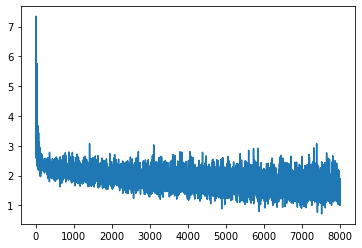


Best Validation Accuracy: 0.482503


In [ ]:
df_rgb=[]
losses = []
counter = 0
best_acc = 0.00
for epoch in range(2):
  

  
  #Each epoch has training and validation phase
  for phase in ['train', 'val']:
    if phase == 'train':
      model.train() # Set model to training mode
    else:
      model.eval() # Set model to evaluate mode
    
    # intiliaze variables to track stats
    running_loss = 0.0
    running_corrects = 0
    iters = 0
 
  
    for data in tqdm(dset_loaders[phase]):
        inputs, labels, _ = data
        
        
        ### If you are using a gpu, then script will move the loaded data to the GPU. 
        ### If you are not using a gpu, ensure that wandb_configs['use_gpu'] is set to False above.
        if wandb_config['use_gpu']:
            inputs = inputs.float().cuda()
            labels = labels.long().cuda()
        else:
            print('WARNING: NOT USING GPU!')
            inputs = inputs.float()
            labels = labels.long()

        
        ### We set the gradients to zero, then calculate the outputs, and the loss function. 
        ### Gradients for this process are automatically calculated by PyTorch.
        
        optimizer_ft.zero_grad()
        # make a forward pass through network
        # use the loss to update weights only if training
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs.data, 1)
          loss = criterion(outputs, labels)

          # backward pass + update parameters only if in training phase
          if phase == 'train':
            
            loss.backward()
            optimizer_ft.step()
            losses.append(loss)
            counter += 1
            df_rgb.append({"model": "ResNet-18 RGB", "n-iterations": counter, "loss": loss.item()})
            clear_output()
            plt.plot(losses)
            plt.show()
        
          ### At this point, the program has calculated gradient of loss w.r.t. weights of our NN model.
          # statistics
          running_corrects += torch.sum(preds == labels.data)
          iters +=1
        
        # update records of accuracy
        epoch_acc = float(running_corrects) / float(data_sizes[phase])
       
        # deep copy model if best so far:
        if phase == 'val' and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model = copy.deepcopy(model)
print('Best Validation Accuracy: {:4f}'.format(best_acc))

In [ ]:
print(best_model)

In [ ]:

# Get Test Accuracy

test_acc = 0.00

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
best_model = best_model.to(dev)
# Use previously calculated best model and set in eval mode
best_model.eval()


# intiliaze variables to track stats
running_corrects = 0
iters = 0

for inputs, labels, _ in tqdm(dset_loaders['test']):
  inputs, labels  = inputs.cuda(), labels.cuda()
  outputs = best_model(inputs)
  _, preds = torch.max(outputs.data, 1)
  
  # statistics
  running_corrects += torch.sum(preds == labels.data)
  iters +=1
  
  # update records of accuracy
  test_acc = float(running_corrects) / float(data_sizes['test'])

print('Test Accuracy: {:4f}'.format(test_acc))


Test Accuracy: 0.474200


# or pytorch get loss.item

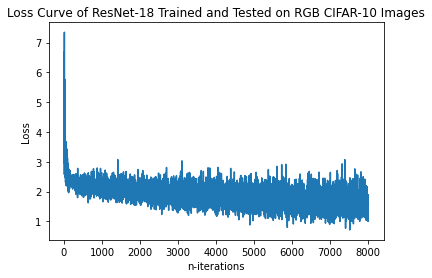

In [ ]:
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("n-iterations")
plt.title("Loss Curve of ResNet-18 Trained and Tested on RGB CIFAR-10 Images")
plt.show()

In [ ]:
# Keep save output in csv
import csv
with open("df_rgb.csv", "w", newline="") as csv_file:
  cols=["model", "n-iterations", "loss"]
  writer= csv.DictWriter(csv_file, fieldnames=cols)
  writer.writeheader()
  writer.writerows(df_rgb)

8003